<a href="https://colab.research.google.com/github/MasoudHadi98/Algo_Trading/blob/main/algo_trading1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**

In [ ]:
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import numpy as np
import seaborn as sns
import bs4 as bs
import requests

import datetime
import warnings
warnings.filterwarnings("ignore")

# install yfinance
!pip install yfinance
import yfinance as yf

#install TA-Lib
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3
import talib as ta

**Import S&P500 Stocks price**

In [ ]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]
start = datetime.datetime(2015,1,1)
end = datetime.datetime(2021,11,1)
data = yf.download(tickers, start=start, end=end)

[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: None


**Import SPY as S&P500 Index**

In [ ]:
start = datetime.datetime(2015,1,1)
end = datetime.datetime(2021,11,1)
spy = yf.download('SPY', start=start, end=end)

[*********************100%***********************]  1 of 1 completed


**Preprocesesing Handel nulls**

In [ ]:
#Preprocesesing Handel nulls
data = data.loc[spy.index]

if data.isnull().values.any() :
    data.fillna(method='backfill',inplace=True)
    data.fillna(method='ffill',inplace=True)
    data.dropna(axis=1,inplace=True)
    print("Total N/A count is : {}".format(data.isnull().sum().sum()))

**Feature extarction**

In [ ]:
spy['Return'] = spy['Adj Close']/spy['Adj Close'].shift(1) - 1
spy['Next Price'] = spy['Adj Close'].shift(-1)
spy['Next Return'] = spy['Return'].shift(-1)
spy['Cumulative Return'] = (1 + spy['Return']).cumprod()
spy['Signal'] = spy['Next Return'].apply(lambda x : 1 if x>(0.005) else (-1 if x<-0.005 else 0 ))

**Normalize data**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

data_scaled = pd.DataFrame()
data_scaled = data.copy()

scaler = MinMaxScaler() 
data_scaled.loc[:,:] = scaler.fit_transform(data_scaled)

take a look at chart

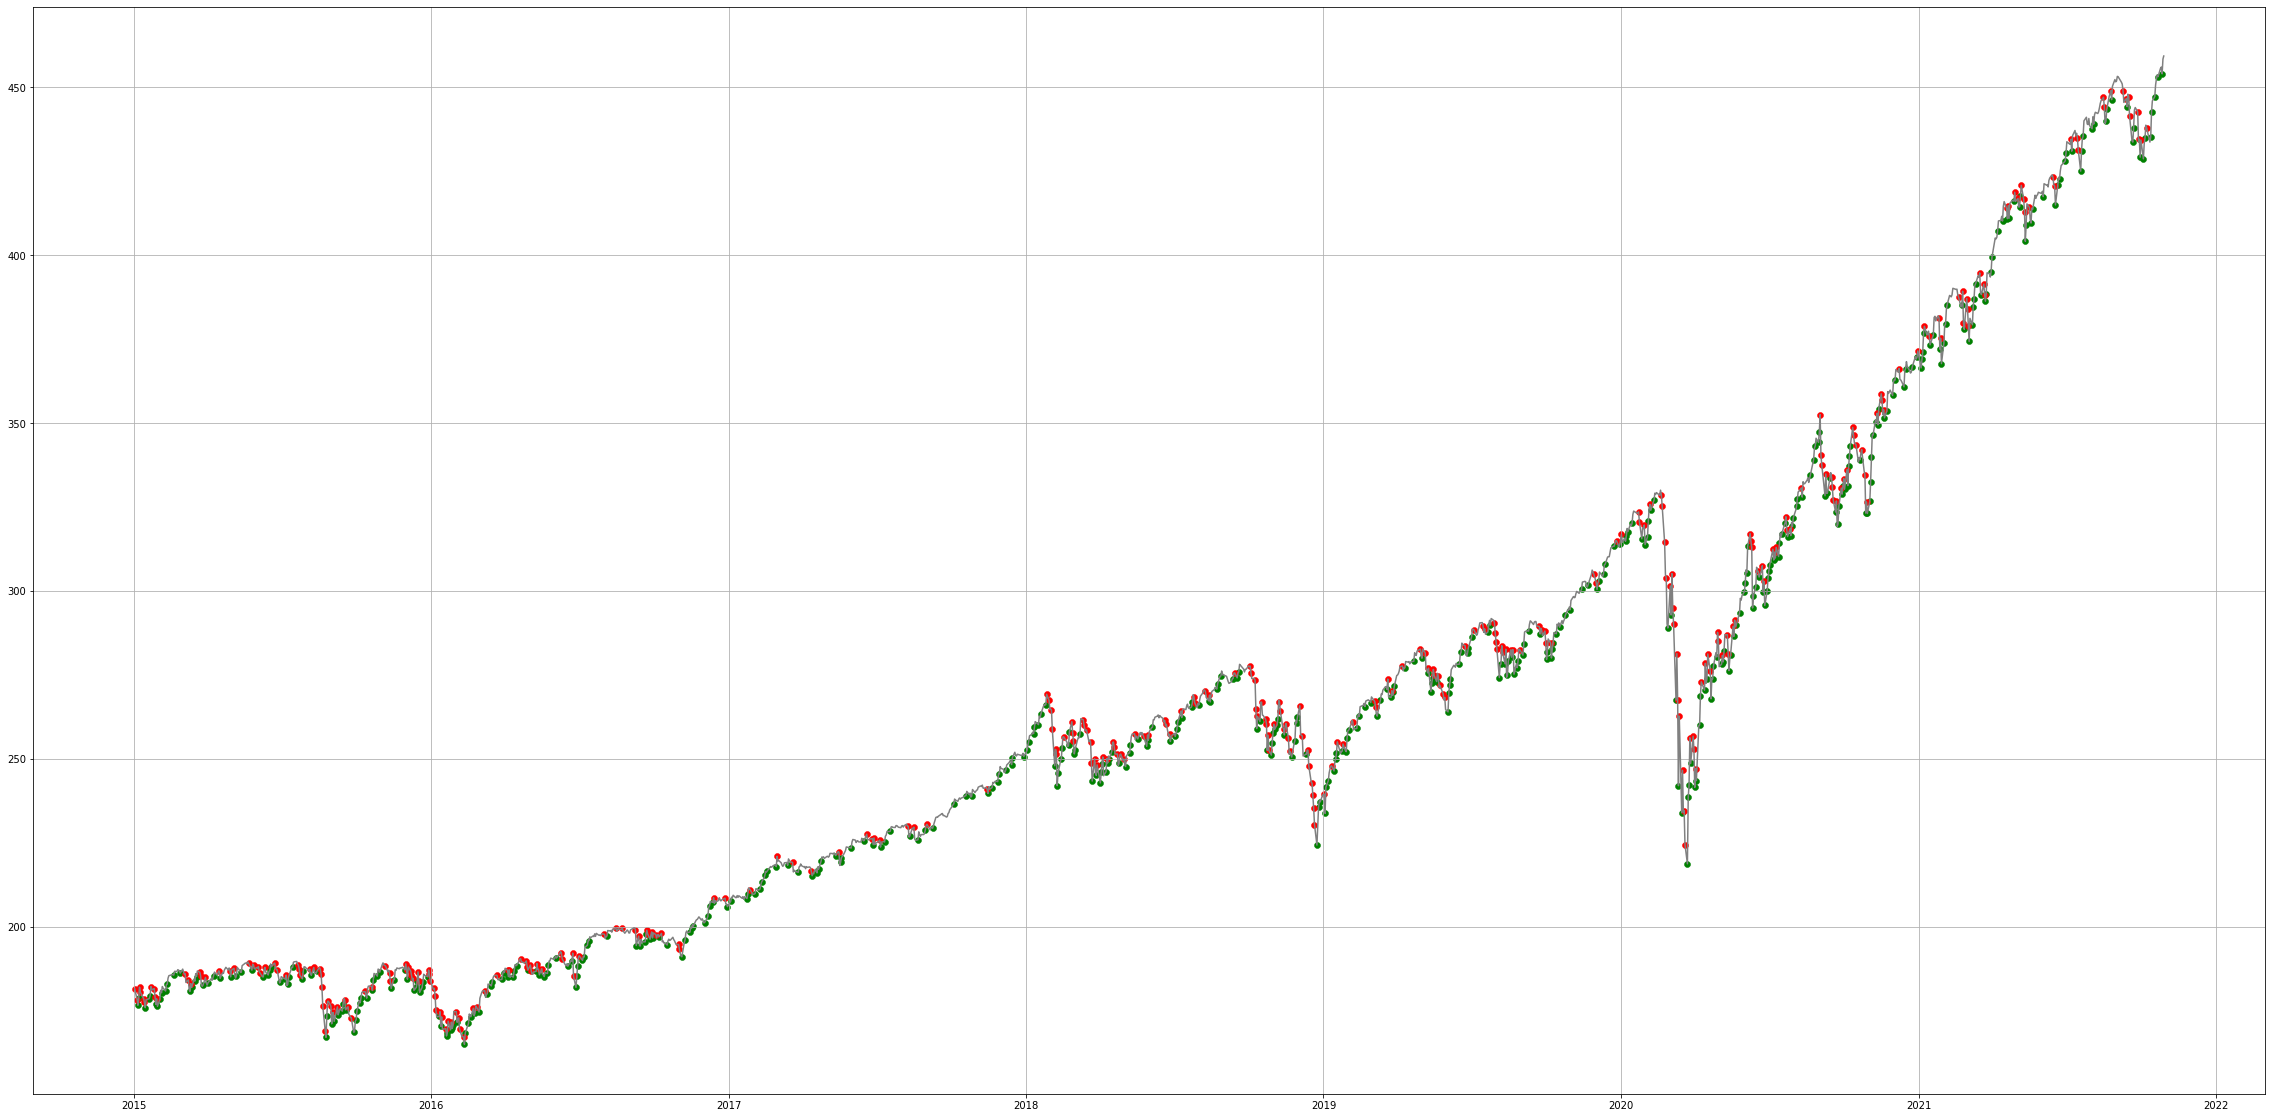

In [ ]:
chart = pd.DataFrame()
chart['Price'] = spy['Adj Close']
chart['Signal'] = spy['Signal']

chart['Hold'] = chart['Price'].loc[chart['Signal']==0]
chart['Buy'] = chart['Price'].loc[chart['Signal']==1]
chart['Sell'] = chart['Price'].loc[chart['Signal']==-1]

plt.figure(figsize=(40,20))
plt.plot(chart['Price'],c='gray')
#plt.scatter(chart.index,chart['Hold'],c='gray',linewidths=0.5)
plt.scatter(chart.index,chart['Buy'],c='green',linewidths=0.5)
plt.scatter(chart.index,chart['Sell'],c='red',linewidths=0.5)
plt.grid()
plt.show()

**Change daily price to WMA5 & RSI**


In [ ]:
# Change daily price to WMA5
df_WMA5 = pd.DataFrame()
for stock in data['Adj Close'].columns :
    df_WMA5[stock] = ta.WMA(data['Adj Close'][stock],timeperiod = 5)
df_WMA5.dropna(inplace=True)

# Change daily price to RSI
df_RSI = pd.DataFrame()
for stock in data['Adj Close'].columns :
    df_RSI[stock] = ta.RSI(data['Adj Close'][stock],timeperiod = 14)
df_RSI.dropna(inplace=True)

In [ ]:
# WMA5 MinMaxScaler
df_WMA5_scaled = pd.DataFrame()
df_WMA5_scaled = df_WMA5.copy()

df_WMA5_scaler = MinMaxScaler() 
df_WMA5_scaled.loc[:,:] = df_WMA5_scaler.fit_transform(df_WMA5_scaled)

# RSI MinMaxScaler
df_RSI_scaled = pd.DataFrame()
df_RSI_scaled = df_RSI.copy()

df_RSI_scaler = MinMaxScaler() 
df_RSI_scaled.loc[:,:] = df_RSI_scaler.fit_transform(df_RSI_scaled)

**New approach to make Test & Train datasets**

In [ ]:
def Test_Train_Maker (x,y):

    length = x.index.shape[0]
    rand = int(np.random.rand() * (length - 500))

    x_train = x.iloc[rand:rand+400]
    x_test = x.iloc[rand+401:rand+501]

    y_train = y.iloc[rand:rand+400]
    y_test = y.iloc[rand+401:rand+501]
    
    return x_train , x_test , y_train , y_test

**Feature Importance**

In [135]:
y = spy['Signal'][spy.index.isin(data['Adj Close'].index)]
X = data_scaled

x_train , x_test , y_train , y_test = Test_Train_Maker(X , y)

In [136]:
from sklearn.ensemble import RandomForestClassifier

fi_forest = RandomForestClassifier(random_state=42)
fi_forest.fit(x_train['Adj Close'], y_train)
FI_Adj = pd.DataFrame()
FI_Adj['Stock'] = data['Adj Close'].columns
FI_Adj['Importance'] = fi_forest.feature_importances_

fi_forest = RandomForestClassifier(random_state=42)
fi_forest.fit(x_train['Volume'], y_train)
FI_Vol = pd.DataFrame()
FI_Vol['Stock'] = data['Volume'].columns
FI_Vol['Importance'] = fi_forest.feature_importances_


fi_forest = RandomForestClassifier(random_state=42)
fi_forest.fit(df_RSI_scaled.loc[x_train.index], y_train)
FI_RSI = pd.DataFrame()
FI_RSI['Stock'] = df_RSI_scaled.columns
FI_RSI['Importance'] = fi_forest.feature_importances_


fi_forest = RandomForestClassifier(random_state=42)
fi_forest.fit(df_WMA5_scaled.loc[x_train.index], y_train)
FI_WMA = pd.DataFrame()
FI_WMA['Stock'] = df_WMA5.columns
FI_WMA['Importance'] = fi_forest.feature_importances_

FI_Total = pd.DataFrame()
FI_Total['Stock'] = data['Adj Close'].columns
FI_Total['Importance'] = 0
for c in FI_Total['Stock'] :
  a = FI_Adj['Importance'].loc[FI_Adj['Stock']== c]
  b = FI_Vol['Importance'].loc[FI_Vol['Stock']== c]
  r = FI_RSI['Importance'].loc[FI_RSI['Stock']== c]
  w = FI_WMA['Importance'].loc[FI_WMA['Stock']== c]
  FI_Total['Importance'].loc[FI_Total['Stock']== c] = a + b + r + w

#FI = FI.sort_values('Importance',ascending=False)
#FI = FI.reset_index()
#VIP = FI['Stock'].loc[:100].values
#print (FI['Stock'].loc[:100].values)

In [137]:
#FI_Total['Stock']
print('start :',x_train.index[0])
print('end :',x_test.index[-1])

VIP = FI_Total.sort_values('Importance',ascending=False).reset_index()[:100]['Stock'].array
Score = FI_Total.sort_values('Importance',ascending=False).reset_index()[:100]['Importance'].array
print(VIP)

start : 2017-04-05 00:00:00
end : 2019-04-02 00:00:00
<PandasArray>
[  'PFG',   'MMM',  'SNPS',  'REGN',  'SBAC',  'WELL',   'AIG',     'D',
   'UPS',   'CAT',    'GD',   'VTR',     'O',   'APA',   'CME',   'AMP',
   'RJF',   'KIM',   'VNO',   'LEN',   'TXN',  'MSCI',   'KMI',   'GPN',
   'CAH',   'CMI',   'JPM',  'ABMD',   'DVN',   'CMS',    'EW',   'BKR',
    'GS',   'ABT',  'XRAY',   'RMD',   'ALB',   'SYY',   'CDW',   'SRE',
    'RE',   'AON',   'FRC',   'HST',   'PEG',  'NLOK',   'ARE',   'PEP',
  'PEAK',   'NVR', 'GOOGL',   'PKG',  'PAYX',    'MA',   'DHI',   'CZR',
   'BAC',   'DLR',   'SLB',     'L',   'UHS',     'F',     'J',   'PSA',
  'VRTX',   'HPE',   'WHR',  'PCAR',   'JNJ',   'XOM',    'BK',   'TSN',
  'CBOE',   'WDC',   'ALK',  'CERN',  'NTRS',   'PSX',     'C',  'WLTW',
  'FANG',   'SWK',   'CCL',   'AMT',   'DFS',   'SEE',   'AXP',   'EXR',
   'GWW',   'FRT',   'CMG',   'GPS',    'WU',   'FDX',  'AMZN',    'MO',
   'LHX',  'CHTR',   'MAA',   'MHK']
Length: 100, dtype:

**Make a new dataset with WMA5 , Vol , RSI**

In [138]:
df_data = pd.DataFrame()

df_data = pd.merge(data_scaled['Adj Close'][VIP]
                   ,data_scaled['Volume'][VIP]
                   ,right_index=True,left_index=True,suffixes=('_adj','_vol'))

df_data = pd.merge(df_data
                   ,df_WMA5_scaled[VIP]
                   ,right_index=True,left_index=True,suffixes=('','wma'))

df_data = pd.merge(df_data
                   ,df_RSI_scaled[VIP]
                   ,right_index=True,left_index=True,suffixes=('','_rsi'))

# SPY MinMaxScaler
SPY_scaled = pd.DataFrame()
SPY_scaled = spy[['Adj Close','Volume']].copy()
SPY_scaler = MinMaxScaler() 
SPY_scaled.loc[:,:] = SPY_scaler.fit_transform(SPY_scaled)

df_data = pd.merge(df_data
                   ,SPY_scaled
                   ,right_index=True,left_index=True,suffixes=('','spy'))

df_data.dropna(axis=0,inplace=True)


**Make a Function to measure performance**

In [139]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    '''
    print the accuracy score, classification report and confusion matrix of classifier
    '''
    if train:
        '''
        training performance
        '''
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))
        """
        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        print('\n')
        """
    elif train==False:
        '''
        test performance
        '''
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))  

In [140]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import normalize

result = pd.DataFrame()
result['Real'] = spy['Signal'][spy.index.isin(x_train.index)]
result['MLP'] = 0
result['RF'] = 0
result['SVM'] = 0
result['KNN'] = 0

In [141]:
#Train Part

mlp = MLPClassifier()
mlp.fit(x_train, y_train)
result['MLP'] = mlp.predict(x_train)
                               
forest = RandomForestClassifier()
ada_rf = AdaBoostClassifier(base_estimator=forest, n_estimators=100, learning_rate=0.5)
ada_rf.fit(x_train, y_train.ravel())
result['RF'] = ada_rf.predict(x_train)

svc = SVC()
svc.fit(x_train, y_train)
result['SVM'] = svc.predict(x_train)

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
result['KNN'] = knn.predict(x_train)

print('MLP :')
print_score(mlp, x_train, y_train, x_test, y_test, train=True)
print_score(mlp, x_train, y_train, x_test, y_test, train=False)
print('RF with Ada :')
print_score(ada_rf, x_train, y_train,x_test, y_test, train=True)
print_score(ada_rf, x_train, y_train,x_test, y_test, train=False)
print('SVC :')
print_score(svc, x_train, y_train,x_test, y_test, train=True)
print_score(svc, x_train, y_train,x_test, y_test, train=False)
print('KNN :')
print_score(knn, x_train, y_train,x_test, y_test, train=True)
print_score(knn, x_train, y_train,x_test, y_test, train=False)

MLP :
Train Result:

accuracy score: 0.7575

Classification Report: 
               precision    recall  f1-score   support

          -1       0.65      0.56      0.60        57
           0       0.76      0.95      0.85       258
           1       0.89      0.29      0.44        85

    accuracy                           0.76       400
   macro avg       0.77      0.60      0.63       400
weighted avg       0.77      0.76      0.73       400


Confusion Matrix: 
 [[ 32  24   1]
 [ 10 246   2]
 [  7  53  25]]

Test Result:

accuracy score: 0.4300

Classification Report: 
               precision    recall  f1-score   support

          -1       0.38      0.26      0.31        23
           0       0.59      0.40      0.48        47
           1       0.35      0.60      0.44        30

    accuracy                           0.43       100
   macro avg       0.44      0.42      0.41       100
weighted avg       0.47      0.43      0.43       100


Confusion Matrix: 
 [[ 6  4 13]
 [ 7

In [142]:
# Test Part

result_test = pd.DataFrame()
result_test['Real'] = spy['Signal'][spy.index.isin(x_test.index)]
result_test['MLP'] = 0
result_test['RF'] = 0
result_test['SVM'] = 0
result_test['KNN'] = 0

for i in y_test.index :

        x_train_loop = df_data.loc[x_train.index.union(x_test.index[x_test.index < i ])]
        y_train_loop = y.loc[y_train.index.union(y_test.index[y_test.index < i ])]
        x_test_loop = df_data.loc[x_test.index[x_test.index == i ]]
        y_test_loop = y.loc[y_test.index[y_test.index == i ]]

        mlp = MLPClassifier()
        mlp.fit(x_train_loop, y_train_loop)
        result_test['MLP'].loc[result_test.index == i] = mlp.predict(x_test_loop)[0]
        
        forest = RandomForestClassifier()
        ada_rf = AdaBoostClassifier(base_estimator=forest, n_estimators=10, learning_rate=0.5)
        ada_rf.fit(x_train_loop, y_train_loop.ravel())
        result_test['RF'].loc[result_test.index == i] = ada_rf.predict(x_test_loop)[0]
        
        svc = SVC()
        svc.fit(x_train_loop, y_train_loop)
        result_test['SVM'].loc[result_test.index == i] = svc.predict(x_test_loop)[0]
        
        knn = KNeighborsClassifier()
        knn.fit(x_train_loop, y_train_loop)
        result_test['KNN'].loc[result_test.index == i] = knn.predict(x_test_loop)[0]     

In [ ]:
#GridSearch for RF
"""
from sklearn.model_selection import GridSearchCV

x_train =X.loc[X.index < test_date]
y_train = y.loc[y.index < test_date]

forest = RandomForestClassifier()

params_grid = {'n_estimators' : [10,20,50,100,200],
                'max_depth' : [5,10,15,20],
                'min_samples_split' : [2,5,7,10,20],
                'min_samples_leaf' : [1,3,5,7,10],
                'max_features' : ["auto", "sqrt", "log2"]}

grid_search = GridSearchCV(forest, params_grid,
                           n_jobs=-1, cv=5,
                           verbose=1, scoring='accuracy')

grid_search.fit(x_train, y_train)

print(grid_search.best_score_)

grid_search.best_estimator_.get_params()
"""

In [143]:
def CLF_Report (Model,y_test,y_model):
    print(Model)
    print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test,y_model)))
    print("Classification Report: \n {}\n".format(classification_report(y_test,y_model)))
    print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test,y_model)))
    
y_test = result_test['Real']
rf_test = result_test['RF']
mlp_test = result_test['MLP']
svc_test = result_test['SVM']
knn_test = result_test['KNN']

CLF_Report('RF',y_test, rf_test)
CLF_Report('MLP',y_test, mlp_test)
CLF_Report('SVM',y_test, svc_test)
CLF_Report('KNN',y_test, knn_test)

RF
accuracy score: 0.4000

Classification Report: 
               precision    recall  f1-score   support

          -1       0.38      0.26      0.31        23
           0       0.46      0.66      0.54        47
           1       0.19      0.10      0.13        30

    accuracy                           0.40       100
   macro avg       0.34      0.34      0.33       100
weighted avg       0.36      0.40      0.36       100


Confusion Matrix: 
 [[ 6 14  3]
 [ 6 31 10]
 [ 4 23  3]]

MLP
accuracy score: 0.3700

Classification Report: 
               precision    recall  f1-score   support

          -1       0.20      0.13      0.16        23
           0       0.43      0.64      0.51        47
           1       0.27      0.13      0.18        30

    accuracy                           0.37       100
   macro avg       0.30      0.30      0.28       100
weighted avg       0.33      0.37      0.33       100


Confusion Matrix: 
 [[ 3 17  3]
 [ 9 30  8]
 [ 3 23  4]]

SVM
accuracy sc

In [144]:
result['past Real'] = result['Real'].shift(1)
result.dropna(axis=0,inplace=True)

result_test['past Real'] = result_test['Real'].shift(1)
result_test.dropna(axis=0,inplace=True)

In [145]:
#Final model with MLP
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

result_test['Final'] = 0
result_test['Bag'] = 0

#Train
y_train_final = result['Real']
y_test_final = result['Real']
x_train_final = result[['RF','MLP','SVM','past Real']]
x_test_final = result_test[['RF','MLP','SVM','past Real']]

"""
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
result['Final'].loc[result.index < test_date] = knn.predict(x_train)
"""

mlp_clf = MLPClassifier()
mlp_clf.fit(x_train_final, y_train_final)
result_test['Final'] = mlp_clf.predict(x_test_final)

clf = DecisionTreeClassifier(random_state=42)
bag_clf = BaggingClassifier(base_estimator=clf, n_estimators=1000,
                            bootstrap=True, n_jobs=-1,
                            random_state=42)
bag_clf.fit(x_train_final, y_train_final.ravel())
result_test['Bag'] = bag_clf.predict(x_test_final)


CLF_Report('Final(MLP)',result_test['Real'], result_test['Final'])
CLF_Report('Final(BAG)',result_test['Real'], result_test['Bag'])

"""
#Test
for i in y.loc[y.index >= test_date].index :
        x_train = X.loc[X.index < i].values
        y_train = y.loc[y.index < i]
        x_test = X.loc[X.index == i].values
        y_test = y.loc[y.index == i]

        #knn = KNeighborsClassifier()
        #knn.fit(x_train, y_train)
        #result['Final'].loc[result.index == i] = knn.predict(x_test)[0]
        
        mlp = MLPClassifier(hidden_layer_sizes = (50,),
                    activation = 'tanh',
                    solver ='adam',
                    alpha = 0.001)
        mlp_clf.fit(x_train, y_train)
        result['Final'].loc[result.index == i] = mlp_clf.predict(x_test)[0]
        
        #mlp = MLPClassifier()
        #mlp_clf.fit(x_train, y_train)
        #result['Final'].loc[result.index == i] = mlp_clf.predict(x_test)[0]
         
        #forest_clf = RandomForestClassifier()
        #ada_rf = AdaBoostClassifier(base_estimator=forest_clf, n_estimators=10, learning_rate=0.5)
        #ada_rf.fit(x_train, y_train.ravel())
        #forest_clf.fit(x_train, y_train.ravel())
        #result['Final'].loc[result.index == i] = ada_rf.predict(x_test)[0]
        #result['Final'].loc[result.index == i] = forest_clf.predict(x_test)[0]
        
        clf = DecisionTreeClassifier(random_state=42)
        bag_clf = BaggingClassifier(base_estimator=clf, n_estimators=1000,
                                    bootstrap=True, n_jobs=-1,
                                    random_state=42)
        bag_clf.fit(x_train, y_train.ravel())
        result['Bag'].loc[result.index == i] = bag_clf.predict(x_test)[0]


y_test = result['Real'].loc[y.index > test_date]
final_test = result['Final'].loc[y.index > test_date]
CLF_Report('Final Test :' , y_test , final_test)
"""

Final(MLP)
accuracy score: 0.3838

Classification Report: 
               precision    recall  f1-score   support

          -1       0.38      0.26      0.31        23
           0       0.45      0.64      0.53        47
           1       0.12      0.07      0.09        29

    accuracy                           0.38        99
   macro avg       0.32      0.32      0.31        99
weighted avg       0.34      0.38      0.35        99


Confusion Matrix: 
 [[ 6 13  4]
 [ 7 30 10]
 [ 3 24  2]]

Final(BAG)
accuracy score: 0.3939

Classification Report: 
               precision    recall  f1-score   support

          -1       0.38      0.26      0.31        23
           0       0.46      0.66      0.54        47
           1       0.13      0.07      0.09        29

    accuracy                           0.39        99
   macro avg       0.32      0.33      0.31        99
weighted avg       0.34      0.39      0.35        99


Confusion Matrix: 
 [[ 6 14  3]
 [ 6 31 10]
 [ 4 23  2]]



"\n#Test\nfor i in y.loc[y.index >= test_date].index :\n        x_train = X.loc[X.index < i].values\n        y_train = y.loc[y.index < i]\n        x_test = X.loc[X.index == i].values\n        y_test = y.loc[y.index == i]\n\n        #knn = KNeighborsClassifier()\n        #knn.fit(x_train, y_train)\n        #result['Final'].loc[result.index == i] = knn.predict(x_test)[0]\n        \n        mlp = MLPClassifier(hidden_layer_sizes = (50,),\n                    activation = 'tanh',\n                    solver ='adam',\n                    alpha = 0.001)\n        mlp_clf.fit(x_train, y_train)\n        result['Final'].loc[result.index == i] = mlp_clf.predict(x_test)[0]\n        \n        #mlp = MLPClassifier()\n        #mlp_clf.fit(x_train, y_train)\n        #result['Final'].loc[result.index == i] = mlp_clf.predict(x_test)[0]\n         \n        #forest_clf = RandomForestClassifier()\n        #ada_rf = AdaBoostClassifier(base_estimator=forest_clf, n_estimators=10, learning_rate=0.5)\n        #

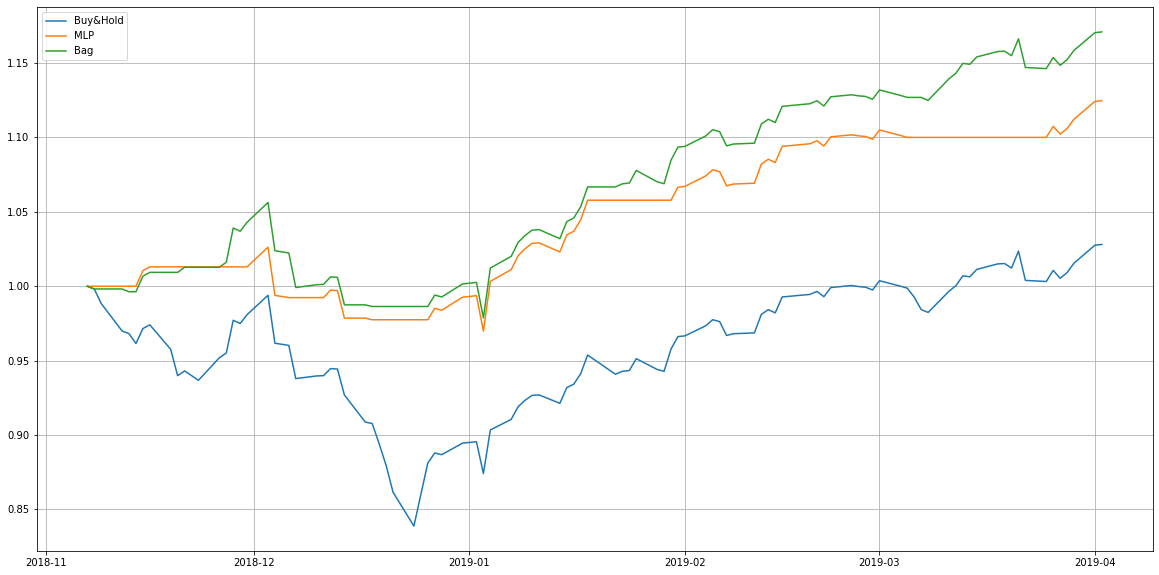

In [146]:
Return = pd.DataFrame()
Return['Return'] = spy['Return'].loc[result_test.index]
Return['Return'][0] = 0
Return['Buy&Hold'] = (1 + Return['Return']).cumprod()

Return['model'] = 1
for idx,val in enumerate(result_test.index) :
    if idx==0:
        Return['model'].iloc[idx] = Return['Buy&Hold'].iloc[0]
    else:
        if result_test['Final'].loc[val] == 1 :
            Return['model'].loc[val] = Return['model'].iloc[idx-1] + Return['Return'].loc[val]
        if result_test['Final'].loc[val] == -1 :
            Return['model'].loc[val] = Return['model'].iloc[idx-1] 
        if result_test['Final'].loc[val] == 0 :
            for i in range(idx):
                if result_test['Final'].iloc[idx-i] == 1 :
                    Return['model'].loc[val] = Return['model'].iloc[idx-1] + Return['Return'].loc[val]
                    break
                if result_test['Final'].iloc[idx-i] == -1 :
                    Return['model'].loc[val] = Return['model'].iloc[idx-i]
                    break
                

Return['Bag'] = 1
for idx,val in enumerate(result_test.index) :
    if idx==0:
        Return['Bag'].iloc[idx] = Return['Buy&Hold'].iloc[0]
    else:
        if result_test['Bag'].loc[val] == 0 :
            Return['Bag'].loc[val] = Return['Bag'].iloc[idx-1] + Return['Return'].loc[val]
        if result_test['Bag'].loc[val] == 1 :
            Return['Bag'].loc[val] = Return['Bag'].iloc[idx-1] + Return['Return'].loc[val]
        if result_test['Bag'].loc[val] == -1 :
            Return['Bag'].loc[val] = Return['Bag'].iloc[idx-1] 
            
plt.figure(figsize=(20,10))
plt.plot(Return['Buy&Hold'],label='Buy&Hold')
plt.plot(Return['model'],label='MLP')
plt.plot(Return['Bag'],label='Bag')

plt.legend()
plt.grid()
plt.show()

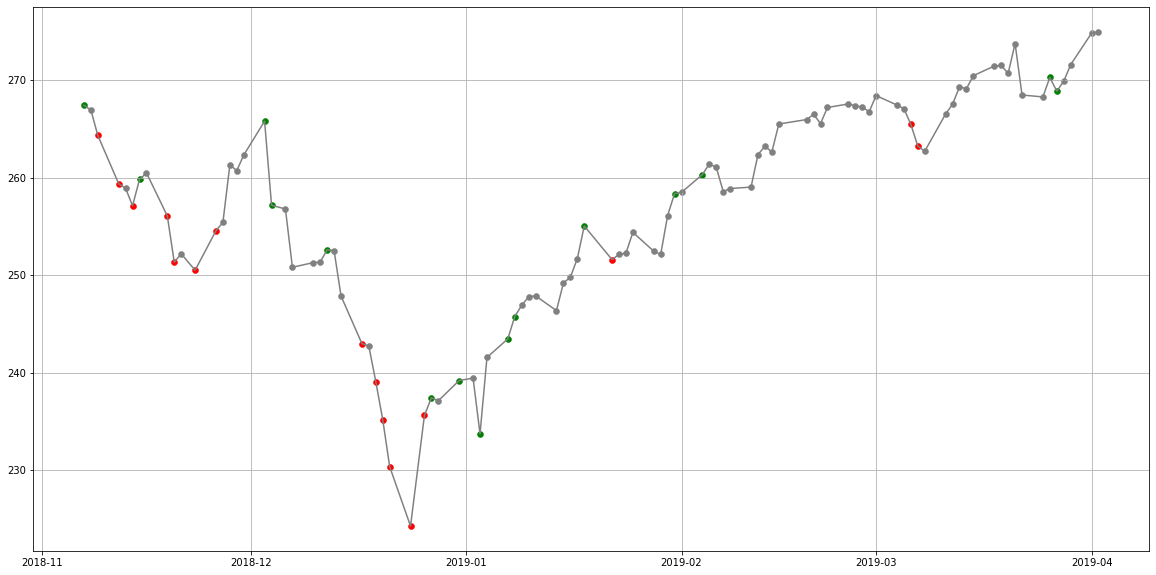

In [147]:
chart = pd.DataFrame()
chart['Price'] = spy['Adj Close'].loc[result_test.index]
chart['Signal'] = result_test['Bag'].loc[result_test.index]

chart['Buy'] = chart['Price'].loc[chart['Signal']==1]
chart['Sell'] = chart['Price'].loc[chart['Signal']==-1]
chart['Hold'] = chart['Price'].loc[chart['Signal']==0]

plt.figure(figsize=(20,10))
plt.plot(chart['Price'],c='gray')
plt.scatter(chart.index,chart['Hold'],c='gray',linewidths=0.5)
plt.scatter(chart.index,chart['Buy'],c='green',linewidths=0.5)
plt.scatter(chart.index,chart['Sell'],c='red',linewidths=0.5)
plt.grid()
plt.show()